In [2]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
torch.manual_seed(0)

# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import model_estimator, EarlyStopper, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
# from utils.preprocessing import 
from utils.functions import  print_nicely, reset_model_weights, plot_tickers_in_data
from utils.modelbuilder import ForwardNeuralNetwork

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

In [37]:
# LOAD DATA
# file_name = "msft_stock.csv"
# data = pd.read_csv("data/" + file_name)
# returns = data["price"].apply(np.log).diff()

# or through yahoo finance
prices = get_ticker_daily_close("MSFT")
returns = prices.apply(np.log).diff()
print(f"Total observations: {len(returns)}")

################################################################
# targets are just the squared returns
targets = returns ** 2

# features for HAR (realized daily/weekly/monthly volatility)
features_har = np.zeros(shape=(len(targets), 3))
features_har[:,0] = targets.shift(1).values
features_har[:,1] = targets.rolling(5).apply(np.mean).shift(1).values
features_har[:,2] = targets.rolling(21).apply(np.mean).shift(1).values
    
# # features and targets to numpy array
features_har = features_har
features = features_har.copy() # or df.values # HAR and NN same input features
targets = targets.values.reshape(-1,1)

# add constant for har features and drop nan values
features_har = sm.add_constant(features_har)

# remove the first few observations due to no estimation for monthly volatility available
start_index = 22
features_har = features_har[start_index:]
features = features[start_index:]
targets = targets[start_index:]

# final overview if features and targets
print(f"shape har featurs: {features_har.shape} of type {type(features_har)}")
print(f"shape nn features: {features.shape} of type {type(features)}")
print(f"shape targets: {targets.shape} of type {type(targets)}")

# split the data into the features set (used for cross validation and ultimately estimating the final model) and testing data
train_size = .8 #.6
features_har, features_har_validation, _placeholder, targets_validation = train_test_split(features_har, targets, shuffle=False, train_size = train_size)
features, features_validation, targets, targets_validation = train_test_split(features, targets, shuffle=False, train_size = train_size)

# # for model specification and final estimation
# features, features_har, targets
# # for model comparison
# features_validation, features_har_validation, targets_validation

Total observations: 9290
shape har featurs: (9268, 4) of type <class 'numpy.ndarray'>
shape nn features: (9268, 3) of type <class 'numpy.ndarray'>
shape targets: (9268, 1) of type <class 'numpy.ndarray'>


In [38]:
def get_avg_vol_daily(ticker):
    prices = get_ticker_daily_close(ticker)
    returns = prices.apply(np.log).diff()
    targets = returns ** 2
    avg_targets = np.mean(targets)
    return avg_targets

In [39]:
stocks = ["MU", "GOLD", "MSFT", "KO", "AAPL", "ASML"]
for stock in stocks:
    print("{:5}: {:1.7%}".format(stock , get_avg_vol_daily(stock)))

MU   : 0.1471712%
GOLD : 0.0708666%
MSFT : 0.0458733%
KO   : 0.0213122%
AAPL : 0.0823958%
ASML : 0.0959228%


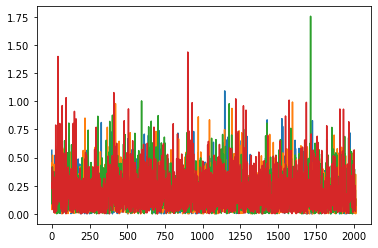

<AxesSubplot:>

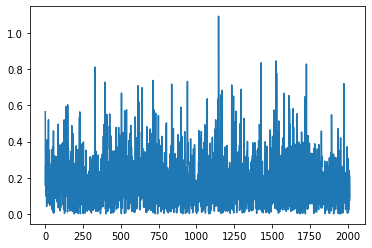

In [45]:
df = pd.read_excel("data/data_2015-2023.xlsx")
df.columns = ("date", "ticker", "ticker2", "vol_realized")
df = df[["date", "ticker", "vol_realized"]]

vol_per_stock = {}
for ticker in df.ticker.unique():
    vol_per_stock[ticker] = df[df["ticker"] == ticker]["vol_realized"].reset_index(drop=True)
    plt.plot(vol_per_stock[ticker])
plt.show()

vol_per_stock["AAPL"].reset_index(drop=True).plot()

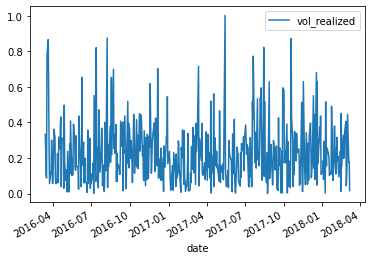

In [50]:
aapl = df[df["ticker"] == "JNJ"]
aapl["date"] = pd.to_datetime(aapl["date"])
aapl = aapl.set_index("date")
aapl.iloc[300:800].plot()
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plot_acf(aapl["vol_realized"].values)
# plt.show()

In [9]:
df = pd.read_csv("data/oxfordmanrealizedvolatilityindices.csv")
df.Symbol.unique()

array(['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI',
       '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX',
       '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20',
       '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC',
       '.SSMI', '.STI', '.STOXX50E'], dtype=object)

In [16]:
df

,Unnamed: 0,Symbol,nobs,medrv,bv_ss,rk_twoscale,open_price,open_time,open_to_close,rv10,close_time,rk_th2,rk_parzen,bv,rsv_ss,rsv,rv5,rv10_ss,rv5_ss,close_price
0,2000-01-03 00:00:00+00:00,.AEX,1795.0,0.000050,0.000100,0.000103,675.67,90101.0,-0.000340,0.000178,163015.0,0.000102,0.000179,0.000100,0.000046,0.000046,0.000130,0.000178,0.000130,675.44
1,2000-01-04 00:00:00+00:00,.AEX,1785.0,0.000075,0.000207,0.000199,664.20,90416.0,-0.033606,0.000261,163016.0,0.000201,0.000423,0.000207,0.000147,0.000147,0.000201,0.000261,0.000201,642.25
2,2000-01-05 00:00:00+00:00,.AEX,1801.0,0.000166,0.000361,0.000325,633.37,90016.0,-0.001675,0.000714,163016.0,0.000345,0.000324,0.000361,0.000328,0.000328,0.000491,0.000714,0.000491,632.31
3,2000-01-06 00:00:00+00:00,.AEX,1799.0,0.000152,0.000258,0.000218,632.46,90016.0,-0.013130,0.000182,163002.0,0.000221,0.000219,0.000258,0.000116,0.000116,0.000225,0.000182,0.000225,624.21
4,2000-01-07 00:00:00+00:00,.AEX,1798.0,0.000039,0.000130,0.000126,628.93,90046.0,0.025013,0.000157,163016.0,0.000123,0.000155,0.000130,0.000048,0.000048,0.000138,0.000157,0.000138,644.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156861,2022-01-18 00:00:00+00:00,.STOXX50E,4257.0,0.000032,0.000081,0.000090,4293.58,90015.0,-0.006784,0.000121,173015.0,0.000090,0.000118,0.000081,0.000059,0.000059,0.000095,0.000121,0.000095,4264.55
156862,2022-01-19 00:00:00+00:00,.STOXX50E,4207.0,0.000048,0.000063,0.000074,4249.40,90015.0,0.002984,0.000059,173003.0,0.000075,0.000079,0.000063,0.000029,0.000029,0.000067,0.000059,0.000067,4262.10
156863,2022-01-20 00:00:00+00:00,.STOXX50E,4142.0,0.000022,0.000047,0.000052,4271.25,90015.0,0.006150,0.000065,173005.0,0.000053,0.000052,0.000047,0.000026,0.000026,0.000054,0.000065,0.000054,4297.60
156864,2022-01-21 00:00:00+00:00,.STOXX50E,4255.0,0.000049,0.000098,0.000159,4278.18,90015.0,-0.012321,0.000163,173002.0,0.000161,0.000168,0.000098,0.000127,0.000127,0.000176,0.000163,0.000176,4225.79


In [1]:
from utils.modelbuilder import ForwardNeuralNetwork

In [2]:
m = ForwardNeuralNetwork(3, 1, [2])
for param in m.parameters():
    print(param)

TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

Parameter containing:
tensor([[-0.4577,  0.4813,  0.5523],
        [-0.5221, -0.1536,  0.3084]], requires_grad=True)
Parameter containing:
tensor([-0.0612, -0.3114], requires_grad=True)
Parameter containing:
tensor([[0.6301, 0.1701]], requires_grad=True)
Parameter containing:
tensor([0.3012], requires_grad=True)


NameError: name 'nn' is not defined

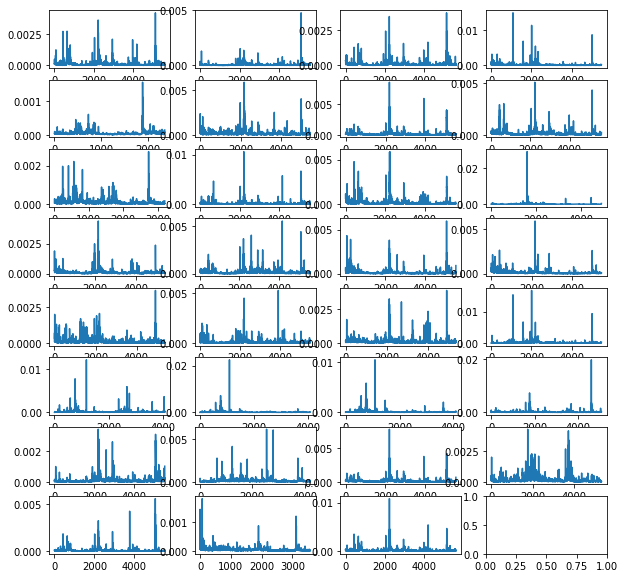

In [3]:
plot_tickers_in_data()